In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import seaborn as sns

from IPython.display import clear_output
from sklearn.metrics import classification_report, accuracy_score, f1_score

/home/maxim/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

!nvidia-smi

CUDA is not available.  Training on CPU ...
cpu
zsh:1: command not found: nvidia-smi


### Подготовка данных для использования
 - Получение Датасета
 - Получение Даталоадера
 - Просмотр данных

In [3]:
train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform=ToTensor()
)
test_dataset = datasets.MNIST(
    root = './data',
    train = False,
    transform=ToTensor()
)

In [4]:
BATCH_SIZE = 64

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [6]:
### Целевое значение
next(iter(train_dataloader))[1]

tensor([3, 7, 9, 6, 0, 6, 2, 4, 5, 1, 5, 5, 5, 9, 3, 8, 0, 4, 1, 3, 0, 8, 0, 3,
        3, 5, 8, 3, 2, 9, 9, 7, 6, 8, 6, 9, 7, 5, 6, 5, 7, 2, 3, 5, 1, 4, 2, 2,
        0, 0, 3, 7, 7, 8, 7, 4, 0, 5, 4, 4, 6, 7, 6, 9])

In [7]:
### Torch tensor
next(iter(train_dataloader))[0].shape

torch.Size([64, 1, 28, 28])

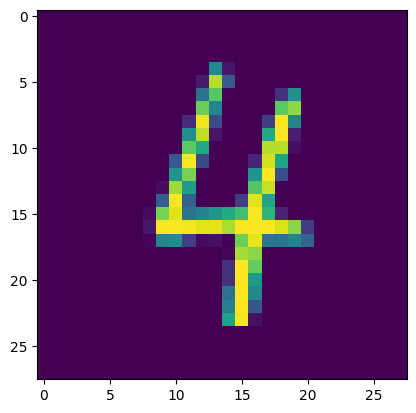

In [8]:
for_show = next(iter(train_dataloader))[0]
plt.imshow(for_show.numpy()[0][0])

### Построим нейронную сеть, чтобы для решения задачи бинарной классфикации (является ли цифра 9-кой или нет)

In [9]:
class IsOne(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.Linear1 = torch.nn.Linear(28*28, 256)
        self.Linear2 = torch.nn.Linear(256, 64)
        self.Linear3 = torch.nn.Linear(64, 1)
        self.relu = torch.nn.ReLU()
        self.Sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        x = x.squeeze(1)
        x = x.flatten(1)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        x = self.relu(x)
        x = self.Linear3(x).squeeze(1)
        x = self.Sigmoid(x)
        return x

In [10]:
model = IsOne()

### Функция, вычисляющая лосс

In [11]:
def loss_function(true, pred):
    loss = torch.nn.BCELoss()
    return loss(pred, true)

### Оптимизатор

In [12]:
optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3)

### Построим процесс обучения нейронной сети

In [13]:
NUM_EPOCHS = 10
WANTED_LABEL = 9

In [14]:
train_loss = []
test_loss = []
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train(True)
    train_loss_epoch = 0
    test_loss_epoch = 0
    for X, y in train_dataloader:
        model.zero_grad()
        true = (y == WANTED_LABEL).float()
        predictions = model.forward(X)
        loss_value = loss_function(true, predictions)
        loss_value.backward()
        train_loss_epoch += loss_value.item()/len(train_dataloader)
        optimizer.step()
    train_loss.append(train_loss_epoch)
    model.train(False)
    for X, y in test_dataloader:
        true = (y == WANTED_LABEL).float()
        predictions = model.forward(X)
        loss_value = loss_function(true, predictions)
        test_loss_epoch += loss_value.item()/len(test_dataloader)
    test_loss.append(test_loss_epoch)
    # print(epoch, train_loss[-1], test_loss[-1])

100%|██████████| 10/10 [01:23<00:00,  8.36s/it]


<AxesSubplot: >

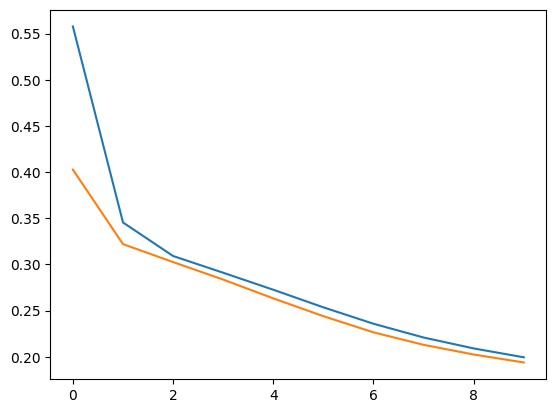

In [15]:
sns.lineplot(train_loss)
sns.lineplot(test_loss)

In [16]:
preds = []
reals = []
for X, y in test_dataloader:
    preds.append(model(X).detach().numpy())
    reals.append((y==WANTED_LABEL).int().numpy())

In [17]:
preds = (np.concatenate(preds)>=0.5).astype(int)

In [18]:
reals = np.concatenate(reals)

In [19]:
accuracy_score(preds, reals), f1_score(reals, preds)

(0.8990384615384616, 0.0)

In [20]:
print(classification_report(reals, preds))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      8976
           1       0.00      0.00      0.00      1008

    accuracy                           0.90      9984
   macro avg       0.45      0.50      0.47      9984
weighted avg       0.81      0.90      0.85      9984



/home/maxim/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/maxim/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/maxim/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Домашняя работа
Изменить нейронную сеть следующим образом:
 - Чтобы она решала задачу не бинарной классификации, а многоклассовой (Для этого нужно использовать другую лосс функцию и функцию активации на выходе)
 - Чтобы в ней было не 2 скрытых слоя, а три
 - Чтобы кол-во нейронов подставлялось через массив, поданный при инициализации класса модели
 - Чтобы происходил dropout (вероятность 0.3) до первого скрытого слоя. Показать, как это изменение повлияло на результат работы модели на тестовой выборке.
 - Посчитать метрики классификации через classification report (sklearn) для каждого класса

In [21]:
batch_size = 64
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
num_features = 10

In [23]:
class Multy(torch.nn.Module):
    def __init__(self):
        super().__init__()                 
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(28*28, 512), 
            torch.nn.Dropout(p=0.3),
            torch.nn.ReLU(),                       
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, num_features),
            torch.nn.ReLU(),
            torch.nn.Softmax(dim = 1)
        )
    def forward(self, x):
        x = x.squeeze(1)
        x = x.flatten(1)
        x = self.seq(x)
        return x

In [24]:
NUM_EPOCHS = 20
criterion = torch.nn.CrossEntropyLoss()
model = Multy().to(device)
# optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3)
optimizer = torch.optim.Adam(model.parameters())

In [25]:
model

Multy(
  (seq): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=10, bias=True)
    (10): ReLU()
    (11): Softmax(dim=1)
  )
)

In [26]:
def train(model, optimizer, epochs=NUM_EPOCHS):  
  train_loss = []
  val_loss = []
  pred = []
  val_acc = []

  for epoch in tqdm(range(epochs)):
      model.train()
      train_loss_epoch = 0
      val_loss_epoch = 0
      for X, y in train_dataloader:
          model.zero_grad()
          features = X.to(device)
          target = y.to(device)
          predictions = model(features)
          loss = criterion(predictions, target)
          loss.backward()
          train_loss_epoch += loss.item()/len(train_dataloader)
          optimizer.step()
      train_loss.append(train_loss_epoch)

      preds = []
      targets = []
      model.eval()
      for X, y in test_dataloader:
          features = X.to(device)
          target = y.to(device)
          predictions = model(features)
          loss = criterion(predictions, target)
          val_loss_epoch += loss.item()/len(test_dataloader)
          preds.append(predictions.argmax(axis = 1).detach().cpu().numpy())
          targets.append(target.cpu().numpy())

      val_loss.append(val_loss_epoch)
      val_acc.append(f1_score(np.concatenate(targets), np.concatenate(preds), average = 'micro'))

      fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
      clear_output(True)
      if train_loss is not None:
          ax.plot(train_loss, label='general train history')
          ax.set_xlabel('Epoch')
          ax.set_title('Train and Val loss')
      if val_loss is not None:
          ax.plot(val_loss, label='general valid history')
      plt.legend()
      plt.show()  

      print(f'\nEpoch: {epoch+1:01}')
      print(f'Train Loss: {train_loss[epoch]:.3f}')
      print(f' Val. Loss: {val_loss[epoch]:.3f} | Val.F_1: {val_acc[epoch]:.3f}')

  return train_loss, val_loss, val_acc

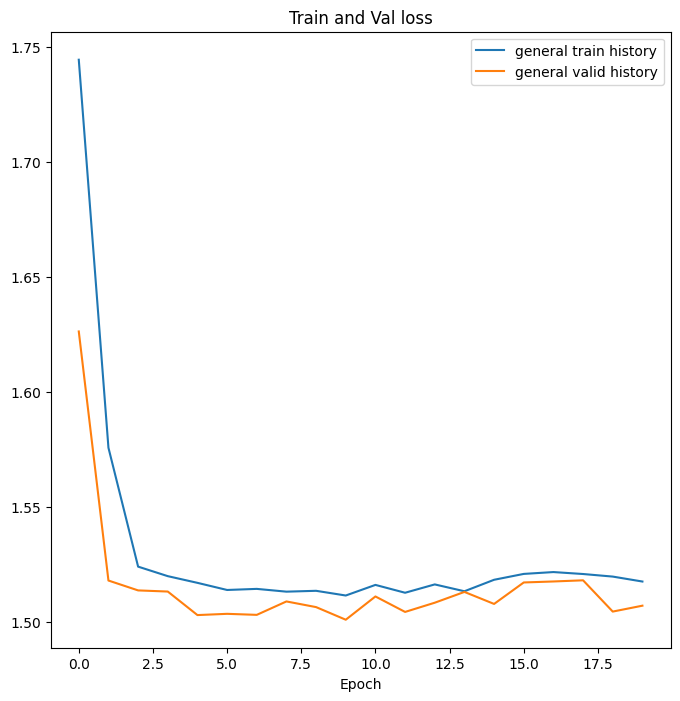

100%|██████████| 20/20 [04:03<00:00, 12.15s/it]


Epoch: 20
Train Loss: 1.518
 Val. Loss: 1.507 | Val.F_1: 0.954


In [27]:
train_history, val_history, val_acc = train(model, optimizer=optimizer)

In [28]:
preds = []
reals = []
for X, y in test_dataloader:
    preds.append(model(X.to(device)).detach().cpu().numpy())
    reals.append(y.to(device).int().cpu().numpy())

In [29]:
preds[0].argmax(axis = 1)

array([6, 3, 6, 9, 2, 4, 4, 8, 8, 9, 8, 1, 5, 8, 2, 4, 9, 0, 9, 3, 7, 4,
       7, 3, 9, 6, 4, 2, 8, 0, 1, 2, 8, 9, 7, 3, 6, 2, 7, 5, 7, 3, 6, 8,
       7, 1, 2, 1, 8, 2, 5, 3, 6, 8, 7, 0, 2, 3, 0, 0, 7, 6, 3, 6])

In [30]:
preds = (np.concatenate(preds).argmax(axis = 1)).astype(int)
len(preds)

9984

In [31]:
reals = np.concatenate(reals)
len(reals)

9984

In [32]:
print(classification_report(reals,preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       980
           1       0.97      0.99      0.98      1134
           2       0.97      0.96      0.96      1031
           3       0.94      0.96      0.95      1009
           4       0.96      0.93      0.94       982
           5       0.98      0.92      0.95       888
           6       0.89      0.99      0.94       956
           7       0.97      0.95      0.96      1024
           8       0.95      0.93      0.94       973
           9       0.94      0.93      0.93      1007

    accuracy                           0.95      9984
   macro avg       0.95      0.95      0.95      9984
weighted avg       0.95      0.95      0.95      9984



### Вывод

1. Модель обучалась 20 эпох и достигла хороший показателей F1 = 0.95
2. Использовились лосс-функция CrossEntropyLoss() и оптимизатор Adam с дефолтными параметрами. 